# utils & framework

In [213]:
from typing import List
from collections.abc import Iterable
from IPython.core.display import Markdown
from scipy.spatial.transform import Rotation
from sympy import *
from sympy.polys.matrices.dense import ddm_ilu_solve
from sympy.vector import *
from win32cryptcon import CRYPT_MODE_OFB

tag_id = 0
conditions = {}
values = {}
formulas_names = {}
restore_stack = []


def reset():
    global tag_id, conditions, values, formulas_names
    if restore_stack:
        state = restore_stack[-1]
        tag_id = state['tag_id']
        conditions = state['conditions'].copy()
        values = state['values'].copy()
        formulas_names = state['formulas_names'].copy()


def push_state():
    global restore_stack
    restore_stack.append({
        'tag_id': tag_id,
        'conditions': conditions.copy(),
        'values': values.copy(),
        'formulas_names': formulas_names.copy()
    })


def pop_state():
    global restore_stack
    return restore_stack.pop()


def save_as_condition(condition):
    global tag_id, conditions
    cached_condition_id = tag_id
    conditions[tag_id] = condition
    tag_id += 1
    return cached_condition_id


def substitute_values(expression, mask=None):
    while True:
        left = False
        items = values.items() if mask is None else filter(lambda item: item[0] in mask, values.items())
        for (key, value) in items:
            before = str(expression)
            expression = expression.subs(key, value)
            expression = simplify(expression)
            if str(expression) != before:
                left = True
        if not left:
            break

    return expression


def save_as_variable(symbol, value):
    global values
    if symbol in values.keys():
        raise ValueError(f"variable {symbol} already exists")
    values[symbol] = substitute_values(S(value))


def save_as_formula_name(symbol, formula):
    global tag_id, formulas_names
    tag_id += 1
    if symbol in formulas_names.keys():
        raise ValueError(f"formula {symbol} already exists")
    formulas_names[symbol] = formula


def beautiful_print(expression, message="", tag=None):
    expression = expression if isinstance(expression, str) else latex(expression)
    inline = not message.endswith('$')
    tag_str = f'\\tag{{{tag}}}' if tag is not None else ""
    if inline:
        full_latex = message + '$' + expression + '$'
    else:
        full_latex = message + '$' + expression + tag_str + '$$'
    display(Markdown(full_latex))


def beautiful_answer(expression, message="$", f: bool = False):
    expression = spf(expression)
    expression = expression.evalf() if f else expression
    beautiful_print(expression, message, tag="answer")


def beautiful_peek(symbol, message="$", tag=None):
    value = substitute_values(symbol)
    beautiful_print(Eq(symbol, value, evaluate=False), message, tag)


def beautiful_solve(cond, variables, apply: dict = None):
    cond = [cond] if not isinstance(cond, Iterable) else cond
    display(Markdown(f"${','.join(f"\\left ( {i} \\right ) " for i in cond)} \\Longrightarrow$"))

    variables = [variables] if not isinstance(variables, Iterable) else variables

    apply = apply if apply is not None else {}

    cond = tuple(map(lambda i: conditions[i].subs(apply), cond))
    solution = solve(cond, tuple(variables), dict=True)[0]
    conclusions = []
    for (variable, conclusion) in solution.items():
        beautiful_print(Eq(variable, conclusion), "$")
        save_as_variable(variable, conclusion)
        conclusions.append(conclusion)


def beautiful_condition(expression, message="$"):
    beautiful_print(expression(False) if callable(expression) else expression, message, tag_id)
    return save_as_condition(expression(True) if callable(expression) else expression)


def beautiful_compute(symbol, expression=None, message="$", tag=None):
    symbol = symbols(symbol) if isinstance(symbol, str) else symbol
    global tag_id
    beautiful_print(Eq(symbol, expression(False) if callable(expression) else expression, evaluate=False), message,
                    tag_id if tag else None)
    if tag:
        tag_id += 1
    save_as_variable(symbol, expression(True) if callable(expression) else expression)
    return symbol


def beautiful_formula(symbol: str, expression, message="$", ):
    beautiful_print(f"{symbol}=" + latex(expression), message, tag_id)
    save_as_formula_name(expression, symbol)
    return expression


def beautiful_at(formula, subs: dict, message="$", tag: bool = None):
    result = simplify(formula.subs(subs))
    param = '\\,'.join(f"{latex(item[0])}={latex(item[1])}" for item in subs.items())
    beautiful_print(formulas_names[formula] + f"\\bigg|_{{{param}}}=" + latex(result), message, tag)
    return result


def spf(expression):
    expression = substitute_values(expression)
    expression = simplify(expression)
    return expression


class D:
    def __init__(self, symbol: Symbol, name: str = None):
        symbol = 'd' + latex(symbol) if name is None else name
        self.symbol = Symbol(symbol)

    def __enter__(self):
        return self.symbol

    def __exit__(self, type, value, traceback):
        save_as_variable(self.symbol, 1)


def map_vector(vec, func):
    return sum(
        # 0 is i/j/k sharp, 1 is expr
        map(lambda item: func(item[1]) * item[0], vec.components.items()),
        Vector.zero
    )


def series_vector(vec, param, x0=0, n=2):
    return map_vector(vec, lambda e: series(e, param, x0, n).removeO())


def integrate_vector(vec, param):
    return map_vector(vec, lambda e: integrate(e, param))


def beautiful_vector(xi=0, yj=0, zk=0):
    xi = Symbol(xi) if isinstance(xi, str) else xi
    yj = Symbol(yj) if isinstance(yj, str) else yj
    zk = Symbol(zk) if isinstance(zk, str) else zk
    return xi * coord.i + yj * coord.j + zk * coord.k


coord = CoordSys3D('')


## Common

In [214]:
epsilon = symbols('epsilon_0')
k = 1 / (4 * pi * epsilon)
q = symbols('q')
x = coord.x
y = coord.y
z = coord.z
pos = x * coord.i + y * coord.j + z * coord.k
E = beautiful_formula('E', k * q * pos / pos.magnitude() ** 3, "by Coulomb's law:$")
electric_flux = Symbol('phi_e')
enclosed_charge_sum = Symbol('Q_{sum}')
Gauss_law = beautiful_condition(Eq(electric_flux, enclosed_charge_sum / epsilon), "by Gauss's law:$")
P = beautiful_formula('\\varphi', k * q / pos.magnitude(), 'electric potential:$')
push_state()

by Coulomb's law:$$E=\left(\frac{\mathbf{{x}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{i}_{}} + \left(\frac{\mathbf{{y}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{j}_{}} + \left(\frac{\mathbf{{z}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{k}_{}}\tag{0}$$

by Gauss's law:$$\phi_{e} = \frac{Q_{sum}}{\epsilon_{0}}\tag{1}$$

electric potential:$$\varphi=\frac{q}{4 \pi \epsilon_{0} \sqrt{\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}}}\tag{2}$$

# 2-5

In [215]:
def t25():
    reset()

    t = Symbol('t')
    x = Function('x')(t)
    V_O = Symbol('V_o')

    av = Symbol('omega')

    r = beautiful_compute('r', 0.1)
    R = beautiful_compute('R', 2 * r)
    beautiful_compute(x, t ** 2)

    V_D = Symbol('V_D')
    cd0 = beautiful_condition(Eq(V_D, V_O + av * R), "by geometry:$")
    cd1 = beautiful_condition(Eq(V_D, diff(x).subs(t, 1)), "by D on line:$")
    cd3 = beautiful_condition(Eq(0, V_O + av * r), "by $V_C=0$:$")
    beautiful_solve([cd0, cd1, cd3], [V_D, av, V_O])
    beautiful_answer(av, "angular velocity:$")

    Vector_av = beautiful_vector(zk=av)
    beautiful_print(Vector_av, "Vecto of angular vec is:$")
    Vector_VO = beautiful_vector(xi=V_O)
    beautiful_print(Vector_VO, "Vector of $V_O$ is:$")

    A_offset = beautiful_vector(yj=R)
    beautiful_print(A_offset, '$A_{offset}$:$')
    V_A = beautiful_compute('V_{A}', Vector_VO + cross(Vector_av, A_offset))
    beautiful_peek(V_A)

    B_offset = beautiful_vector(yj=r)
    beautiful_print(B_offset, '$B_{offset}$:$')
    V_B = beautiful_compute('V_{B}', Vector_VO + cross(Vector_av, B_offset))
    beautiful_peek(V_B)

    C_offset = beautiful_vector(yj=-r)
    beautiful_print(C_offset, '$C_{offset}$:$')
    V_C = beautiful_compute('V_{C}', Vector_VO + cross(Vector_av, C_offset))
    beautiful_peek(V_C)

    D_offset = beautiful_vector(yj=-R)
    beautiful_print(D_offset, '$D_{offset}$:$')
    V_D = beautiful_compute('V_{D}', Vector_VO + cross(Vector_av, D_offset))
    beautiful_peek(V_D)

    E_offset = beautiful_vector(xi=R)
    beautiful_print(E_offset, '$E_{offset}$:$')
    V_E = beautiful_compute('V_{E}', Vector_VO + cross(Vector_av, E_offset))
    beautiful_peek(V_E)


t25()


$$r = 0.1$$

$$R = 2 r$$

$$x{\left(t \right)} = t^{2}$$

by geometry:$$V_{D} = R \omega + V_{o}\tag{3}$$

by D on line:$$V_{D} = \left. \frac{d}{d t} x{\left(t \right)} \right|_{\substack{ t=1 }}\tag{4}$$

by $V_C=0$:$$0 = V_{o} + \omega r\tag{5}$$

$\left ( 3 \right ) ,\left ( 4 \right ) ,\left ( 5 \right )  \Longrightarrow$

$$V_{D} = \left. \frac{d}{d t} x{\left(t \right)} \right|_{\substack{ t=1 }}$$

$$V_{o} = \frac{r \left. \frac{d}{d t} x{\left(t \right)} \right|_{\substack{ t=1 }}}{- R + r}$$

$$\omega = - \frac{\left. \frac{d}{d t} x{\left(t \right)} \right|_{\substack{ t=1 }}}{- R + r}$$

angular velocity:$$20.0\tag{answer}$$

Vecto of angular vec is:$$\left(\omega\right)\mathbf{\hat{k}_{}}$$

Vector of $V_O$ is:$$\left(V_{o}\right)\mathbf{\hat{i}_{}}$$

$A_{offset}$:$$\left(R\right)\mathbf{\hat{j}_{}}$$

$$V_{A} = \left(- R \omega + V_{o}\right)\mathbf{\hat{i}_{}}$$

$$V_{A} = \left(-6.0\right)\mathbf{\hat{i}_{}}$$

$B_{offset}$:$$\left(r\right)\mathbf{\hat{j}_{}}$$

$$V_{B} = \left(V_{o} - \omega r\right)\mathbf{\hat{i}_{}}$$

$$V_{B} = \left(-4.0\right)\mathbf{\hat{i}_{}}$$

$C_{offset}$:$$\left(- r\right)\mathbf{\hat{j}_{}}$$

$$V_{C} = \left(V_{o} + \omega r\right)\mathbf{\hat{i}_{}}$$

$$V_{C} = \mathbf{\hat{0}}$$

$D_{offset}$:$$\left(- R\right)\mathbf{\hat{j}_{}}$$

$$V_{D} = \left(R \omega + V_{o}\right)\mathbf{\hat{i}_{}}$$

$$V_{D} = \left(2.0\right)\mathbf{\hat{i}_{}}$$

$E_{offset}$:$$\left(R\right)\mathbf{\hat{i}_{}}$$

$$V_{E} = \left(V_{o}\right)\mathbf{\hat{i}_{}} + \left(R \omega\right)\mathbf{\hat{j}_{}}$$

$$V_{E} = \left(-2.0\right)\mathbf{\hat{i}_{}} + \left(4.0\right)\mathbf{\hat{j}_{}}$$

# 2-14

In [216]:
def t214():
    reset()
    t = Symbol('t')
    theta = Function('theta')(t)
    V_A = Symbol('V_{A}', positive=True)
    R = Symbol('R')

    x_d = Function('x_d')(t)
    y_d = Function('y_d')(t)
    cd1 = beautiful_condition(Eq(R, x_d * sin(theta)), "by geometry:$")
    cd2 = beautiful_condition(Eq(x_d, y_d * tan(theta)), "by geometry:$")
    beautiful_solve([cd1, cd2], [y_d, theta])
    beautiful_peek(y_d, "so in world coordinates:$", "answer")

    x_ld = Symbol('x_{localD}')
    y_ld = Symbol('y_{localD}')
    theta_l = Symbol('\\theta_{local}')
    cd1 = beautiful_condition(Eq(y_ld, x_ld * tan(theta_l)), "by geometry:$")
    cd2 = beautiful_condition(Eq(y_ld * tan(theta_l), R), "by geometry:$")
    beautiful_solve([cd1, cd2], [x_ld, theta_l])
    beautiful_peek(x_ld, "so in local coordinates:$", "answer")
    beautiful_compute(x_d, R / sin(theta), "by geometry:$")

    beautiful_compute(diff(x_d, t), V_A, "by geometry:$")
    av = beautiful_compute('omega', diff(theta, t), "so:$")
    av = substitute_values(av).subs(x_d, R / sin(theta)).simplify().refine(Q.positive(cos(theta)))
    beautiful_print(av, "inlined:$", tag="answer")
    aav = -beautiful_compute('alpha', lambda e: diff(av, t, evaluate=e), "so:$")
    aav = substitute_values(aav).subs(x_d, R / sin(theta)).simplify().refine(Q.positive(cos(theta))).simplify()
    beautiful_print(aav, "inlined:$", tag="answer")

    Vector_Va = beautiful_vector(xi=V_A)
    beautiful_print(Vector_Va, "Vector of $V_A$ is:$")
    Vector_av = beautiful_vector(zk=av)
    beautiful_print(Vector_av, "Vector of angular vel is:$")
    C_offset = beautiful_vector(xi=- R * cos(theta) / tan(theta), yj=R * cos(theta))
    beautiful_print(C_offset, "$C_{offset}$:$")
    V_C = Vector_Va + cross(Vector_av, C_offset)
    V_C = V_C.simplify()
    beautiful_print(V_C, "Vector of $V_{C}$ is:$")

    beautiful_print(V_C.magnitude().simplify().refine(Q.positive(cos(theta))), "Size:$", tag="answer")

    Vector_aav = beautiful_vector(zk=aav)
    beautiful_print(Vector_aav, "Vector of acc angular vel is:$")

    A_C = diff(V_A, t) * coord.i + cross(Vector_aav, C_offset) + Vector_av.cross(cross(Vector_av, C_offset))
    beautiful_print(A_C, "Acc $A_{C}$:$")
    A_C = A_C.simplify().refine(Q.positive(cos(theta)))
    beautiful_print(A_C, "simplified $A_{C}$:$")
    beautiful_print(A_C.magnitude().simplify().refine(Q.positive(cos(theta))), "Size:$", tag="answer")


t214()

by geometry:$$R = x_{d}{\left(t \right)} \sin{\left(\theta{\left(t \right)} \right)}\tag{3}$$

by geometry:$$x_{d}{\left(t \right)} = y_{d}{\left(t \right)} \tan{\left(\theta{\left(t \right)} \right)}\tag{4}$$

$\left ( 3 \right ) ,\left ( 4 \right )  \Longrightarrow$

$$\theta{\left(t \right)} = \pi - \operatorname{asin}{\left(\frac{R}{x_{d}{\left(t \right)}} \right)}$$

$$y_{d}{\left(t \right)} = - \frac{\sqrt{- \frac{R^{2}}{x_{d}^{2}{\left(t \right)}} + 1} x_{d}^{2}{\left(t \right)}}{R}$$

so in world coordinates:$$y_{d}{\left(t \right)} = - \frac{\sqrt{- \frac{R^{2}}{x_{d}^{2}{\left(t \right)}} + 1} x_{d}^{2}{\left(t \right)}}{R}\tag{answer}$$

by geometry:$$y_{localD} = x_{localD} \tan{\left(\theta_{local} \right)}\tag{5}$$

by geometry:$$y_{localD} \tan{\left(\theta_{local} \right)} = R\tag{6}$$

$\left ( 5 \right ) ,\left ( 6 \right )  \Longrightarrow$

$$\theta_{local} = \operatorname{atan}{\left(\frac{R}{y_{localD}} \right)}$$

$$x_{localD} = \frac{y_{localD}^{2}}{R}$$

so in local coordinates:$$x_{localD} = \frac{y_{localD}^{2}}{R}\tag{answer}$$

by geometry:$$x_{d}{\left(t \right)} = \frac{R}{\sin{\left(\theta{\left(t \right)} \right)}}$$

by geometry:$$\frac{d}{d t} x_{d}{\left(t \right)} = V_{A}$$

so:$$\omega = \frac{d}{d t} \theta{\left(t \right)}$$

inlined:$$\frac{V_{A} \sin^{2}{\left(\theta{\left(t \right)} \right)}}{R \cos{\left(\theta{\left(t \right)} \right)}}\tag{answer}$$

so:$$\alpha = \frac{\partial}{\partial t} \frac{V_{A} \sin^{2}{\left(\theta{\left(t \right)} \right)}}{R \cos{\left(\theta{\left(t \right)} \right)}}$$

inlined:$$\frac{V_{A}^{2} \left(\sin^{2}{\left(\theta{\left(t \right)} \right)} - 2\right) \tan^{3}{\left(\theta{\left(t \right)} \right)}}{R^{2}}\tag{answer}$$

Vector of $V_A$ is:$$\left(V_{A}\right)\mathbf{\hat{i}_{}}$$

Vector of angular vel is:$$\left(\frac{V_{A} \sin^{2}{\left(\theta{\left(t \right)} \right)}}{R \cos{\left(\theta{\left(t \right)} \right)}}\right)\mathbf{\hat{k}_{}}$$

$C_{offset}$:$$\left(- \frac{R \cos{\left(\theta{\left(t \right)} \right)}}{\tan{\left(\theta{\left(t \right)} \right)}}\right)\mathbf{\hat{i}_{}} + \left(R \cos{\left(\theta{\left(t \right)} \right)}\right)\mathbf{\hat{j}_{}}$$

Vector of $V_{C}$ is:$$\left(V_{A} \cos^{2}{\left(\theta{\left(t \right)} \right)}\right)\mathbf{\hat{i}_{}} + \left(- \frac{V_{A} \sin{\left(2 \theta{\left(t \right)} \right)}}{2}\right)\mathbf{\hat{j}_{}}$$

Size:$$V_{A} \cos{\left(\theta{\left(t \right)} \right)}\tag{answer}$$

Vector of acc angular vel is:$$\left(\frac{V_{A}^{2} \left(\sin^{2}{\left(\theta{\left(t \right)} \right)} - 2\right) \tan^{3}{\left(\theta{\left(t \right)} \right)}}{R^{2}}\right)\mathbf{\hat{k}_{}}$$

Acc $A_{C}$:$$\left(- \frac{V_{A}^{2} \left(\sin^{2}{\left(\theta{\left(t \right)} \right)} - 2\right) \cos{\left(\theta{\left(t \right)} \right)} \tan^{3}{\left(\theta{\left(t \right)} \right)}}{R} + \frac{V_{A}^{2} \sin^{4}{\left(\theta{\left(t \right)} \right)}}{R \cos{\left(\theta{\left(t \right)} \right)} \tan{\left(\theta{\left(t \right)} \right)}}\right)\mathbf{\hat{i}_{}} + \left(- \frac{V_{A}^{2} \left(\sin^{2}{\left(\theta{\left(t \right)} \right)} - 2\right) \cos{\left(\theta{\left(t \right)} \right)} \tan^{2}{\left(\theta{\left(t \right)} \right)}}{R} - \frac{V_{A}^{2} \sin^{4}{\left(\theta{\left(t \right)} \right)}}{R \cos{\left(\theta{\left(t \right)} \right)}}\right)\mathbf{\hat{j}_{}}$$

simplified $A_{C}$:$$\left(\frac{V_{A}^{2} \left(3 - 2 \sin^{2}{\left(\theta{\left(t \right)} \right)}\right) \sin^{3}{\left(\theta{\left(t \right)} \right)}}{R \cos^{2}{\left(\theta{\left(t \right)} \right)}}\right)\mathbf{\hat{i}_{}} + \left(\frac{2 V_{A}^{2} \sin^{2}{\left(\theta{\left(t \right)} \right)} \cos{\left(\theta{\left(t \right)} \right)}}{R}\right)\mathbf{\hat{j}_{}}$$

Size:$$V_{A}^{2} \sqrt{\frac{\left(\left(2 \sin^{2}{\left(\theta{\left(t \right)} \right)} - 3\right)^{2} \sin^{2}{\left(\theta{\left(t \right)} \right)} + 4 \cos^{6}{\left(\theta{\left(t \right)} \right)}\right) \tan^{4}{\left(\theta{\left(t \right)} \right)}}{R^{2}}}\tag{answer}$$

In [217]:
def t215():
    reset()
    t = Symbol('t')
    angle = Function('\\theta')(t)
    angular_vel = diff(angle, t)
    angular_acc = diff(angular_vel, t)
    x_a = Function('x_a')(t)
    d_xa = diff(x_a, t)
    dd_xa = diff(d_xa, t)
    y_a = Symbol('y_a')
    length = Symbol('l')
    beautiful_compute(angle, atan(y_a / x_a), "by geometry:$")

    x_b = beautiful_compute(Function('x_b')(t), x_a + length * cos(angle), "by geometry:$")
    y_b = beautiful_compute(Function('y_b')(t), y_a + length * sin(angle), "by geometry:$")

    beautiful_peek(diff(x_b, t), "so:$")
    beautiful_peek(diff(y_b, t), )

    beautiful_peek(diff(x_b, t, 2), "so:$")
    beautiful_peek(diff(y_b, t, 2), )

    beautiful_compute(length, 0.1953, "given:$")
    beautiful_compute(y_a, -0.10, "given:$")
    beautiful_compute(dd_xa, 0.1, "given:$")
    beautiful_compute(d_xa, -0.15, "given:$")
    beautiful_compute(x_a, -0.075, "given:$")

    beautiful_peek(diff(x_b, t), "so:$")
    beautiful_peek(diff(y_b, t), )

    beautiful_peek(diff(x_b, t, 2), )
    beautiful_peek(diff(y_b, t, 2), )

    beautiful_peek(angular_vel)
    beautiful_peek(angular_acc)


t215()

by geometry:$$\theta{\left(t \right)} = \operatorname{atan}{\left(\frac{y_{a}}{x_{a}{\left(t \right)}} \right)}$$

by geometry:$$x_{b}{\left(t \right)} = l \cos{\left(\theta{\left(t \right)} \right)} + x_{a}{\left(t \right)}$$

by geometry:$$y_{b}{\left(t \right)} = l \sin{\left(\theta{\left(t \right)} \right)} + y_{a}$$

so:$$\frac{d}{d t} x_{b}{\left(t \right)} = \frac{l y_{a}^{2} \frac{d}{d t} x_{a}{\left(t \right)}}{\left(\frac{y_{a}^{2}}{x_{a}^{2}{\left(t \right)}} + 1\right)^{\frac{3}{2}} x_{a}^{3}{\left(t \right)}} + \frac{d}{d t} x_{a}{\left(t \right)}$$

$$\frac{d}{d t} y_{b}{\left(t \right)} = - \frac{l y_{a} \sqrt{\frac{y_{a}^{2}}{x_{a}^{2}{\left(t \right)}} + 1} x_{a}^{2}{\left(t \right)} \frac{d}{d t} x_{a}{\left(t \right)}}{\left(y_{a}^{2} + x_{a}^{2}{\left(t \right)}\right)^{2}}$$

so:$$\frac{d^{2}}{d t^{2}} x_{b}{\left(t \right)} = \frac{3 l y_{a}^{4} \left(y_{a}^{2} + x_{a}^{2}{\left(t \right)}\right)^{3} \left(\frac{d}{d t} x_{a}{\left(t \right)}\right)^{2} + l y_{a}^{2} \left(y_{a}^{2} + x_{a}^{2}{\left(t \right)}\right)^{4} x_{a}{\left(t \right)} \frac{d^{2}}{d t^{2}} x_{a}{\left(t \right)} - 3 l y_{a}^{2} \left(y_{a}^{2} + x_{a}^{2}{\left(t \right)}\right)^{4} \left(\frac{d}{d t} x_{a}{\left(t \right)}\right)^{2} + \left(\frac{y_{a}^{2} + x_{a}^{2}{\left(t \right)}}{x_{a}^{2}{\left(t \right)}}\right)^{\frac{11}{2}} x_{a}^{12}{\left(t \right)} \frac{d^{2}}{d t^{2}} x_{a}{\left(t \right)}}{\left(\frac{y_{a}^{2} + x_{a}^{2}{\left(t \right)}}{x_{a}^{2}{\left(t \right)}}\right)^{\frac{11}{2}} x_{a}^{12}{\left(t \right)}}$$

$$\frac{d^{2}}{d t^{2}} y_{b}{\left(t \right)} = \frac{l y_{a} \left(- y_{a}^{2} x_{a}{\left(t \right)} \frac{d^{2}}{d t^{2}} x_{a}{\left(t \right)} - y_{a}^{2} \left(\frac{d}{d t} x_{a}{\left(t \right)}\right)^{2} - x_{a}^{3}{\left(t \right)} \frac{d^{2}}{d t^{2}} x_{a}{\left(t \right)} + 2 x_{a}^{2}{\left(t \right)} \left(\frac{d}{d t} x_{a}{\left(t \right)}\right)^{2}\right)}{\sqrt{\frac{y_{a}^{2} + x_{a}^{2}{\left(t \right)}}{x_{a}^{2}{\left(t \right)}}} \left(y_{a}^{4} + 2 y_{a}^{2} x_{a}^{2}{\left(t \right)} + x_{a}^{4}{\left(t \right)}\right) x_{a}{\left(t \right)}}$$

given:$$l = 0.1953$$

given:$$y_{a} = -0.1$$

given:$$\frac{d^{2}}{d t^{2}} x_{a}{\left(t \right)} = 0.1$$

given:$$\frac{d}{d t} x_{a}{\left(t \right)} = -0.15$$

given:$$x_{a}{\left(t \right)} = -0.075$$

so:$$\frac{d}{d t} x_{b}{\left(t \right)} = -9.60000000002625 \cdot 10^{-6}$$

$$\frac{d}{d t} y_{b}{\left(t \right)} = -0.1124928$$

$$\frac{d^{2}}{d t^{2}} x_{b}{\left(t \right)} = -0.323972864$$

$$\frac{d^{2}}{d t^{2}} y_{b}{\left(t \right)} = 0.092994048$$

$$\frac{d}{d t} \theta{\left(t \right)} = -0.96$$

$$\frac{d^{2}}{d t^{2}} \theta{\left(t \right)} = 2.0224$$

# 2-16
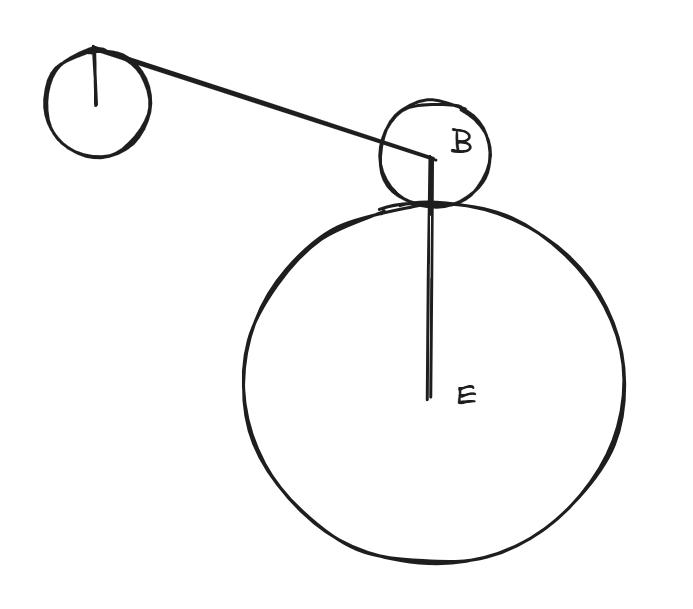

In [218]:
def t216():
    reset()
    r = Symbol('r', positive=True)
    length = Symbol('l')
    t = Symbol('t')
    R_ball = Symbol('R_{ball}')
    R_track = Symbol('R_{track}')

    # beautiful_compute(length,0.4,"given:$")
    # beautiful_compute(r,0.1,"given:$")
    # beautiful_compute(R_ball,0.1,"given:$")
    # beautiful_compute(R_track,0.4,"given:$")
    beautiful_compute(length, 4 * r, "given:$")
    beautiful_compute(R_ball, 1 * r, "given:$")
    beautiful_compute(R_track, 4 * r, "given:$")

    R = beautiful_compute('R', R_ball + R_track, "by geometry:$")
    x_offset = beautiful_compute('x_{offset}', sqrt(length ** 2 - r ** 2), "by geometry:$")

    angle_O = Function('\\theta_{O}')(t)
    angle_E = Function('\\theta_{E}')(t)
    d_angle_E = diff(angle_E, t)
    dd_angle_E = diff(d_angle_E, t)

    P1 = beautiful_vector(r * cos(angle_O), r * sin(angle_O))
    P2 = beautiful_vector(R * cos(angle_E) + x_offset, R * sin(angle_E) - R)
    tmp = beautiful_compute('len(Pos_{A}-Pos_{B})-AB=0', (P1 - P2).magnitude() ** 2 - length ** 2, "by geometry:$")
    tmp = substitute_values(tmp).expand().simplify()
    beautiful_print(tmp, "so:$")

    tmp1 = diff(tmp, t).simplify()
    cd1 = beautiful_condition(tmp1, "diff it , and got zero")
    beautiful_solve(cd1, d_angle_E)

    tmp2 = diff(tmp1, t).simplify()
    cd2 = beautiful_condition(tmp2, "diff it and got zero")
    beautiful_solve(cd2, dd_angle_E)

    beautiful_compute(diff(angle_O, t, 2), 0, "at init:$")
    beautiful_compute(diff(angle_O, t), 10, "at init:$")
    beautiful_compute(angle_O, pi / 2, "at init:$")
    beautiful_compute(angle_E, pi / 2, "at init:$")

    beautiful_peek(d_angle_E)
    beautiful_peek(dd_angle_E)

    angle_B = Function('\\theta_{B}')(t)
    beautiful_compute(angle_B, angle_E * 5, "by geometry:$")
    angle_B = angle_E * 5
    beautiful_peek(diff(angle_B, t), "so:$")
    beautiful_peek(diff(angle_B, t, 2), "so:$")

    beautiful_compute(r, 0.1, "given:$")
    beautiful_peek(diff(angle_B, t), "so:$", tag="answer")
    beautiful_peek(diff(angle_B, t, 2), "so:$", tag="answer")


t216()

given:$$l = 4 r$$

given:$$R_{ball} = r$$

given:$$R_{track} = 4 r$$

by geometry:$$R = R_{ball} + R_{track}$$

by geometry:$$x_{offset} = \sqrt{l^{2} - r^{2}}$$

by geometry:$$len(Pos_{A}-Pos_{B})-AB=0 = - l^{2} + \left(- R \sin{\left(\theta_{E}{\left(t \right)} \right)} + R + r \sin{\left(\theta_{O}{\left(t \right)} \right)}\right)^{2} + \left(- R \cos{\left(\theta_{E}{\left(t \right)} \right)} + r \cos{\left(\theta_{O}{\left(t \right)} \right)} - x_{offset}\right)^{2}$$

so:$$r^{2} \left(- 50 \sin{\left(\theta_{E}{\left(t \right)} \right)} + 10 \sin{\left(\theta_{O}{\left(t \right)} \right)} - 10 \cos{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 10 \sqrt{15} \cos{\left(\theta_{E}{\left(t \right)} \right)} - 2 \sqrt{15} \cos{\left(\theta_{O}{\left(t \right)} \right)} + 50\right)$$

diff it , and got zero$2 r^{2} \left(5 \left(\frac{d}{d t} \theta_{E}{\left(t \right)} - \frac{d}{d t} \theta_{O}{\left(t \right)}\right) \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} - 5 \sqrt{15} \sin{\left(\theta_{E}{\left(t \right)} \right)} \frac{d}{d t} \theta_{E}{\left(t \right)} + \sqrt{15} \sin{\left(\theta_{O}{\left(t \right)} \right)} \frac{d}{d t} \theta_{O}{\left(t \right)} - 25 \cos{\left(\theta_{E}{\left(t \right)} \right)} \frac{d}{d t} \theta_{E}{\left(t \right)} + 5 \cos{\left(\theta_{O}{\left(t \right)} \right)} \frac{d}{d t} \theta_{O}{\left(t \right)}\right)$

$\left ( 3 \right )  \Longrightarrow$

$$\frac{d}{d t} \theta_{E}{\left(t \right)} = - \frac{5 \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} \frac{d}{d t} \theta_{O}{\left(t \right)}}{- 5 \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 5 \sqrt{15} \sin{\left(\theta_{E}{\left(t \right)} \right)} + 25 \cos{\left(\theta_{E}{\left(t \right)} \right)}} + \frac{\sqrt{15} \sin{\left(\theta_{O}{\left(t \right)} \right)} \frac{d}{d t} \theta_{O}{\left(t \right)}}{- 5 \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 5 \sqrt{15} \sin{\left(\theta_{E}{\left(t \right)} \right)} + 25 \cos{\left(\theta_{E}{\left(t \right)} \right)}} + \frac{5 \cos{\left(\theta_{O}{\left(t \right)} \right)} \frac{d}{d t} \theta_{O}{\left(t \right)}}{- 5 \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 5 \sqrt{15} \sin{\left(\theta_{E}{\left(t \right)} \right)} + 25 \cos{\left(\theta_{E}{\left(t \right)} \right)}}$$

diff it and got zero$2 r^{2} \left(5 \left(\frac{d}{d t} \theta_{E}{\left(t \right)} - \frac{d}{d t} \theta_{O}{\left(t \right)}\right)^{2} \cos{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 5 \left(\frac{d^{2}}{d t^{2}} \theta_{E}{\left(t \right)} - \frac{d^{2}}{d t^{2}} \theta_{O}{\left(t \right)}\right) \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 25 \sin{\left(\theta_{E}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{E}{\left(t \right)}\right)^{2} - 5 \sqrt{15} \sin{\left(\theta_{E}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{E}{\left(t \right)} - 5 \sin{\left(\theta_{O}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{O}{\left(t \right)}\right)^{2} + \sqrt{15} \sin{\left(\theta_{O}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{O}{\left(t \right)} - 5 \sqrt{15} \cos{\left(\theta_{E}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{E}{\left(t \right)}\right)^{2} - 25 \cos{\left(\theta_{E}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{E}{\left(t \right)} + \sqrt{15} \cos{\left(\theta_{O}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{O}{\left(t \right)}\right)^{2} + 5 \cos{\left(\theta_{O}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{O}{\left(t \right)}\right)$

$\left ( 4 \right )  \Longrightarrow$

$$\frac{d^{2}}{d t^{2}} \theta_{E}{\left(t \right)} = - \frac{5 \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{O}{\left(t \right)}}{- 5 \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 5 \sqrt{15} \sin{\left(\theta_{E}{\left(t \right)} \right)} + 25 \cos{\left(\theta_{E}{\left(t \right)} \right)}} + \frac{25 \sin{\left(\theta_{E}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{E}{\left(t \right)}\right)^{2}}{- 5 \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 5 \sqrt{15} \sin{\left(\theta_{E}{\left(t \right)} \right)} + 25 \cos{\left(\theta_{E}{\left(t \right)} \right)}} - \frac{5 \sin{\left(\theta_{O}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{O}{\left(t \right)}\right)^{2}}{- 5 \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 5 \sqrt{15} \sin{\left(\theta_{E}{\left(t \right)} \right)} + 25 \cos{\left(\theta_{E}{\left(t \right)} \right)}} + \frac{\sqrt{15} \sin{\left(\theta_{O}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{O}{\left(t \right)}}{- 5 \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 5 \sqrt{15} \sin{\left(\theta_{E}{\left(t \right)} \right)} + 25 \cos{\left(\theta_{E}{\left(t \right)} \right)}} + \frac{5 \cos{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{E}{\left(t \right)}\right)^{2}}{- 5 \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 5 \sqrt{15} \sin{\left(\theta_{E}{\left(t \right)} \right)} + 25 \cos{\left(\theta_{E}{\left(t \right)} \right)}} - \frac{10 \cos{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} \frac{d}{d t} \theta_{E}{\left(t \right)} \frac{d}{d t} \theta_{O}{\left(t \right)}}{- 5 \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 5 \sqrt{15} \sin{\left(\theta_{E}{\left(t \right)} \right)} + 25 \cos{\left(\theta_{E}{\left(t \right)} \right)}} + \frac{5 \cos{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{O}{\left(t \right)}\right)^{2}}{- 5 \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 5 \sqrt{15} \sin{\left(\theta_{E}{\left(t \right)} \right)} + 25 \cos{\left(\theta_{E}{\left(t \right)} \right)}} - \frac{5 \sqrt{15} \cos{\left(\theta_{E}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{E}{\left(t \right)}\right)^{2}}{- 5 \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 5 \sqrt{15} \sin{\left(\theta_{E}{\left(t \right)} \right)} + 25 \cos{\left(\theta_{E}{\left(t \right)} \right)}} + \frac{\sqrt{15} \cos{\left(\theta_{O}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{O}{\left(t \right)}\right)^{2}}{- 5 \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 5 \sqrt{15} \sin{\left(\theta_{E}{\left(t \right)} \right)} + 25 \cos{\left(\theta_{E}{\left(t \right)} \right)}} + \frac{5 \cos{\left(\theta_{O}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{O}{\left(t \right)}}{- 5 \sin{\left(\theta_{E}{\left(t \right)} - \theta_{O}{\left(t \right)} \right)} + 5 \sqrt{15} \sin{\left(\theta_{E}{\left(t \right)} \right)} + 25 \cos{\left(\theta_{E}{\left(t \right)} \right)}}$$

at init:$$\frac{d^{2}}{d t^{2}} \theta_{O}{\left(t \right)} = 0$$

at init:$$\frac{d}{d t} \theta_{O}{\left(t \right)} = 10$$

at init:$$\theta_{O}{\left(t \right)} = \frac{\pi}{2}$$

at init:$$\theta_{E}{\left(t \right)} = \frac{\pi}{2}$$

$$\frac{d}{d t} \theta_{E}{\left(t \right)} = 2$$

$$\frac{d^{2}}{d t^{2}} \theta_{E}{\left(t \right)} = - \frac{4 \sqrt{15}}{3}$$

by geometry:$$\theta_{B}{\left(t \right)} = 5 \theta_{E}{\left(t \right)}$$

so:$$5 \frac{d}{d t} \theta_{E}{\left(t \right)} = 10$$

so:$$5 \frac{d^{2}}{d t^{2}} \theta_{E}{\left(t \right)} = - \frac{20 \sqrt{15}}{3}$$

given:$$r = 0.1$$

so:$$5 \frac{d}{d t} \theta_{E}{\left(t \right)} = 10\tag{answer}$$

so:$$5 \frac{d^{2}}{d t^{2}} \theta_{E}{\left(t \right)} = - \frac{20 \sqrt{15}}{3}\tag{answer}$$

# 2-19
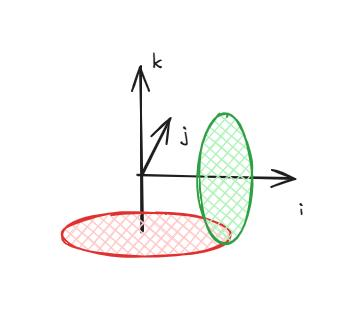

In [219]:
def t219():
    reset()
    V_a = beautiful_compute('V_a', 0.2, "given:$")
    AB = beautiful_compute('AB', 0.1 * sqrt(2), "given:$")
    R = beautiful_compute('R', AB, "given:$")

    V_C = beautiful_compute('V_C', 0, "by pure roll:$")
    D_yaw = beautiful_compute('\\omega_{yaw}', V_a / R, "easily:$")
    dis_a = beautiful_compute('d_{A}', R * sin(pi / 4), "by geometry:$")
    D_axis = beautiful_compute('\\omega_{axis}', - V_a / dis_a, "easily:$")
    V_B = beautiful_compute('V_B', D_axis * 2 * R * sin(pi / 4), "easily:$")
    beautiful_peek(V_B, "inlined:$", tag="answer")

    D_axis = substitute_values(D_axis)
    Vector_av = beautiful_vector(xi=D_axis * cos(pi / 4), zk=-D_axis * sin(pi / 4))
    beautiful_print(Vector_av, "as vector:$")

    DD_axis = beautiful_compute('\\varepsilon_{axis}', D_yaw * D_axis * cos(pi / 4), "the angular acceleration:$")
    beautiful_peek(DD_axis, "inlined:$")
    DD_axis = substitute_values(DD_axis)

    Vector_aav = beautiful_vector(yj=DD_axis)
    beautiful_print(Vector_aav, "as vector:$")

    C_offset = beautiful_vector(R, 0, -R)
    C_offset = substitute_values(C_offset)
    beautiful_print(C_offset, "C offset as vector:$")
    A_C = cross(Vector_aav, C_offset) + Vector_av.cross(cross(Vector_av, C_offset))
    # A_C = cross( C_offset,Vector_aav) + cross(cross(C_offset,Vector_av),Vector_av)
    beautiful_print(A_C, "acc of C:$")

    B_offset = beautiful_vector(R, 0, R)
    B_offset = substitute_values(B_offset)
    beautiful_print(B_offset, "B offset as vector:$")
    B_C = cross(Vector_aav, B_offset) + Vector_av.cross(cross(Vector_av, B_offset))
    beautiful_print(B_C, "acc of B:$")


t219()

given:$$V_{a} = 0.2$$

given:$$AB = 0.1 \sqrt{2}$$

given:$$R = AB$$

by pure roll:$$V_{C} = 0$$

easily:$$\omega_{yaw} = \frac{V_{a}}{R}$$

by geometry:$$d_{A} = \frac{\sqrt{2} R}{2}$$

easily:$$\omega_{axis} = - \frac{V_{a}}{d_{A}}$$

easily:$$V_{B} = \sqrt{2} R \omega_{axis}$$

inlined:$$V_{B} = -0.4\tag{answer}$$

as vector:$$\left(- 1.0 \sqrt{2}\right)\mathbf{\hat{i}_{}} + \left(1.0 \sqrt{2}\right)\mathbf{\hat{k}_{}}$$

the angular acceleration:$$\varepsilon_{axis} = - 1.0 \sqrt{2} \omega_{yaw}$$

inlined:$$\varepsilon_{axis} = -2.0$$

as vector:$$\left(-2.0\right)\mathbf{\hat{j}_{}}$$

C offset as vector:$$\left(0.1 \sqrt{2}\right)\mathbf{\hat{i}_{}} + \left(- 0.1 \sqrt{2}\right)\mathbf{\hat{k}_{}}$$

acc of C:$$\left(0.2 \sqrt{2}\right)\mathbf{\hat{i}_{}} + \left(0.2 \sqrt{2}\right)\mathbf{\hat{k}_{}}$$

B offset as vector:$$\left(0.1 \sqrt{2}\right)\mathbf{\hat{i}_{}} + \left(0.1 \sqrt{2}\right)\mathbf{\hat{k}_{}}$$

acc of B:$$\left(- 0.6 \sqrt{2}\right)\mathbf{\hat{i}_{}} + \left(- 0.2 \sqrt{2}\right)\mathbf{\hat{k}_{}}$$

# 2-20
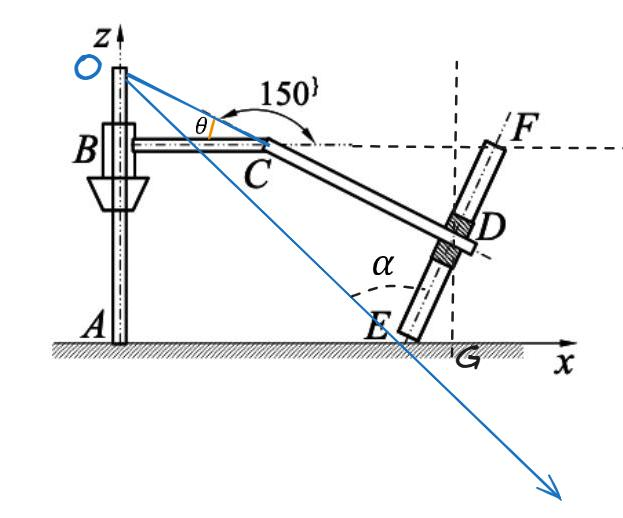

In [220]:
def t220():
    reset()
    r = beautiful_compute('r', 0.1, "given:$")
    av_yaw = beautiful_compute('\\omega_{yaw}', 10)
    Vector_av_yaw = beautiful_vector(zk=av_yaw)
    beautiful_print(Vector_av_yaw, "as vector:$")

    theta = beautiful_compute('theta', pi / 6)
    CD = beautiful_compute('CD', 0.01 * 5 * sqrt(3))
    BC = beautiful_compute('BC', 0.01 * 7.5)
    ED = beautiful_compute('ED', r)
    DF = beautiful_compute('DF', r)
    EF = beautiful_compute('EF', ED + DF)
    AB = beautiful_compute('AB', CD * sin(theta) + ED * cos(theta), "by geometry:$")
    beautiful_peek(AB, "inlined:$")
    OA = beautiful_compute('OA', AB + BC * tan(theta), "by geometry:$")
    beautiful_peek(OA, "inlined:$")
    AG = beautiful_compute('AG', BC + CD * cos(theta), "by geometry:$")
    beautiful_peek(AG, "inlined:$")
    AE = beautiful_compute('AE', AG - ED * sin(theta), "by geometry:$")
    beautiful_peek(AE, "inlined:$")

    alpha = beautiful_compute('alpha', pi - (pi / 2 - theta) - atan(OA / AE), "by geometry:$")
    beautiful_peek(alpha, "inlined:$")
    V_D = beautiful_compute('V_D', av_yaw * AG, "so:$")
    dist_D = beautiful_compute('dist_D', sin(alpha) * ED, "by geometry:$")

    av_axis = beautiful_compute('\\omega_{axis}', -V_D / dist_D, "so:$")
    beautiful_peek(av_axis, "inlined:$")
    Vector_av = beautiful_vector(xi=AE, zk=-OA)
    Vector_av = Vector_av * av_axis / Vector_av.magnitude()
    Vector_av = substitute_values(Vector_av)

    beautiful_print(Vector_av, " angular vel as vector:$", tag="answer")
    Vector_aav = cross(Vector_av_yaw, Vector_av)
    Vector_aav = substitute_values(Vector_aav)
    beautiful_print(Vector_aav, "angular acc as vector:$", tag="answer")

    F_offset = beautiful_vector(xi=AE + EF * sin(theta), zk=-OA + EF * cos(theta))
    F_offset = substitute_values(F_offset)
    beautiful_print(F_offset, "F offset as vector:$")

    V_F = cross(Vector_av, F_offset)
    beautiful_print(V_F, "vel of F:$", tag="answer")
    A_F = cross(Vector_aav, F_offset) + Vector_av.cross(cross(Vector_av, F_offset))
    beautiful_print(A_F, "acc of F:$", tag="answer")


t220()

given:$$r = 0.1$$

$$\omega_{yaw} = 10$$

as vector:$$\left(\omega_{yaw}\right)\mathbf{\hat{k}_{}}$$

$$\theta = \frac{\pi}{6}$$

$$CD = 0.05 \sqrt{3}$$

$$BC = 0.075$$

$$ED = r$$

$$DF = r$$

$$EF = DF + ED$$

by geometry:$$AB = CD \sin{\left(\theta \right)} + ED \cos{\left(\theta \right)}$$

inlined:$$AB = 0.075 \sqrt{3}$$

by geometry:$$OA = AB + BC \tan{\left(\theta \right)}$$

inlined:$$OA = 0.1 \sqrt{3}$$

by geometry:$$AG = BC + CD \cos{\left(\theta \right)}$$

inlined:$$AG = 0.15$$

by geometry:$$AE = AG - ED \sin{\left(\theta \right)}$$

inlined:$$AE = 0.1$$

by geometry:$$\alpha = \theta - \operatorname{atan}{\left(\frac{OA}{AE} \right)} + \frac{\pi}{2}$$

inlined:$$\alpha = - \operatorname{atan}{\left(1.0 \sqrt{3} \right)} + \frac{2 \pi}{3}$$

so:$$V_{D} = AG \omega_{yaw}$$

by geometry:$$dist_{D} = ED \sin{\left(\alpha \right)}$$

so:$$\omega_{axis} = - \frac{V_{D}}{dist_{D}}$$

inlined:$$\omega_{axis} = - 10.0 \sqrt{3}$$

 angular vel as vector:$$\left(- 5.0 \sqrt{3}\right)\mathbf{\hat{i}_{}} + \left(15.0\right)\mathbf{\hat{k}_{}}\tag{answer}$$

angular acc as vector:$$\left(- 50.0 \sqrt{3}\right)\mathbf{\hat{j}_{}}\tag{answer}$$

F offset as vector:$$\left(0.2\right)\mathbf{\hat{i}_{}}$$

vel of F:$$\left(3.0\right)\mathbf{\hat{j}_{}}\tag{answer}$$

acc of F:$$\left(-45.0\right)\mathbf{\hat{i}_{}} + \left(- 5.0 \sqrt{3}\right)\mathbf{\hat{k}_{}}\tag{answer}$$